## Jupyter notebooks for BLaSA analysis and predictions
- Jupyter notebooks are a sequence of cells, whose output is stored
- Cells must be run for their output to be used
- Click on a cell or use <kbd>&#8593;</kbd> <kbd>&#8595;</kbd> keys to select
- To execute a cell type <kbd>ctrl</kbd>+<kbd>enter</kbd>

In [1]:
import os, time, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas, json
from scipy.optimize import minimize
from scipy.integrate import cumtrapz
from scipy.interpolate import UnivariateSpline

## Location of data files

In [19]:
with open("../run/input.json", "r") as f:
    input_data = json.load(f)
dump_folder = os.path.join('../run',input_data['dump_folder'])
print(dump_folder)
energy_data = np.loadtxt(os.path.join(dump_folder,"E_data"))

../run/sample_data


# Mean field approach for the fcc lattice

### Unit Lattice Vectors: 

$\hat{\bf a}_1=[110]/\sqrt{2},\quad$
$\hat{\bf a}_2=[1\bar{1}0]/\sqrt{2},\quad$ 

$\hat{\bf a}_3=[101]/\sqrt{2},\quad$
$\hat{\bf a}_4=[10\bar{1}]/\sqrt{2},\quad$ 

$\hat{\bf a}_5=[011]/\sqrt{2},\quad$
$\hat{\bf a}_6=[01\bar{1}]/\sqrt{2},\quad$ 

$\hat{\bf a}_{l+6}\equiv-\hat{\bf a}_{l+6}$

$
{\bf G}_{1l}\hat{\bf a}_l\equiv\hat{\bf a}_1,\quad
\Rightarrow
\quad
\hat{\bf a}_1{\bf G}_{1l} = \hat{\bf a}_l,\quad
$
$\delta{\bf b}\equiv {\bf b}-\langle{\bf b}\rangle,\quad$

---

$
V_\parallel\left(x+\langle{\rm b}_\parallel\rangle \right) = D_0\left(1-e^{-\alpha{x}}\right)^2\to 
D_0\alpha^2{x}^2
,\quad
|x|\ll1
$

---

$
\tilde{U}(\delta{\bf b})
=
    \frac{1}{2}
    \sum_{l\neq1,1+m}
    V_1\left({\bf G}_{1l}\cdot\delta{\bf b}+\langle{\bf b}\rangle \right)
    =
    \frac{1}{2}
    \sum_{l\neq1,1+m}
    V_\parallel\left(\hat{\bf a}_l\cdot\delta{\bf b}+\langle{\rm b}_\parallel\rangle\right)
    +
    \kappa D_0\alpha^2
    \left(
    |\delta{\bf b}|^2-|\hat{\bf a}_l\cdot\delta{\bf b}|^2
    \right)
    ,
$

### Bond Vectors in cylindrical coordinates with axis along ${\bf a}_1$ :

$
\delta{\bf b} = [\delta{\rm b}_\parallel,\delta{\rm b}_\perp\cos(\phi),\delta{\rm b}_\perp\sin(\phi)]
$

$
\hat{\bf a}_1 = [1,0,0] \Rightarrow 
,\quad 
\hat{\bf a}_{2-5} = [1/2,\pm\sqrt{3/8},\pm\sqrt{3/8}]
,\quad 
\hat{\bf a}_6 = [0,1,0]
$

$
\hat{\bf a}_1\cdot\delta{\bf b} = \delta{\rm b}_\parallel
,\quad
\hat{\bf a}_7\cdot\delta{\bf b} = - \hat{\bf a}_1\cdot\delta{\bf b}
$

$
\hat{\bf a}_{2-5}\cdot\delta{\bf b} = \delta{\rm b}_\parallel/2 \pm\sqrt{3/4}\delta{\rm b}_\perp\sin(\phi\pm\pi/4)
,\quad\hat{\bf a}_{8-11}\cdot\delta{\bf b} = - \hat{\bf a}_{2-5}\cdot\delta{\bf b}
$

$
\hat{\bf a}_6\cdot\delta{\bf b} = \cos(\phi){\rm b}_\perp
,\quad\hat{\bf a}_1\cdot\delta{\bf b} = - \hat{\bf a}_2\cdot\delta{\bf b}
$

# Potential Parameters

In [20]:
kb = 8.617e-5
D = input_data['potential']['D0']
a0 = input_data['potential']['a0']
AL = input_data['potential']['AL']
print(D,a0,AL)

0.1 2.856 0.75


# Morse potential and fit / solve routines

In [21]:
def boltz(fun,T):
    f = np.exp(-(fun - fun.min())/kb/T)
    return f/f.sum()

In [22]:
def morse(r):
    return D*(1.0+np.exp(-2.0*AL*(r-a0))-2.0*np.exp(-AL*(r-a0)))#D*AL*AL*(r-a0)**2#

In [23]:
def dmorse(r):
    return -2.0*AL*D*(np.exp(-2.0*AL*(r-a0))-np.exp(-AL*(r-a0)))#D*AL*AL*(r-a0)**2#

In [24]:
def ddmorse(r):
    return D*AL*AL*(2.0*np.exp(-2.0*AL*(r-a0))-np.exp(-AL*(r-a0))) # 

In [25]:
"""
Effective potential is seperable into 
longitudinal and transverse components by the observed independence 
of the parallel and perpendicular bond components
"""
def long_potential(r,am=1.0,fsc=0.0,rt=1.0,T=0.1):
    
    # x_0 = x_0, x_1 = x_0 + (r-am)
    aa = am*a0
    dr = r-aa
    dV = fsc*dr + morse(r)
    dV += 2.0*morse(aa+dr/2.0)+2.0*morse(aa-dr/2.0) + rt*(4.0*D*AL*AL)*dr**2
    V = np.exp(-dV/kb/T)
    V = -np.log(V)*kb*T
    
    return V - V.min()

In [26]:
def tran_potential(r,T=0.1,am=1.0,fsc=0.0,rt=1.0,dint=True):
    
    aa = am*a0
    tc = rt*D*AL*AL
    lc = ddmorse(aa)
    
    if dint:

        theta = np.linspace(-np.pi,np.pi,20,endpoint=True)
        c = np.cos(theta)
        su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
        sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
        F = np.zeros(r.size) #

        for i in range(r.size):
            V = morse(su*r[i]+aa)+morse(sd*r[i]+aa)+morse(-su*r[i]+aa)+morse(-sd*r[i]+aa)    
            V += morse(c*r[i]+aa)/2.0+morse(-c*r[i]+aa)/2.0 
            V += tc*(3.5+c*c)*r[i]*r[i]
            II = np.exp(-V/kb/T).sum()
            F[i] += -kb*T*np.log(II.copy())
    else:
        
        F = np.zeros(r.size) #
        for theta in [0.0,np.pi/4.0,np.pi/2.0,3.0*np.pi/4.0]:
            c = np.cos(theta)
            su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
            sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
            V = morse(su*r+aa)+morse(sd*r+aa)+morse(-su*r+aa)+morse(-sd*r+aa)    
            V += morse(c*r+aa)/2.0+morse(-c*r+aa)/2.0 
            F += np.exp(-V/kb/T)
        F = -kb*T*np.log(F) + tc*(3.5+c*c)*r*r
    return F-F[0]

In [27]:
"""
Determination of lambda parameter
"""
def find_linear_correction(T=0.1,nstep=10000,minr=0.1,maxr=5.0,am=1.0,rt=1.0):
        
        # base on quad value
        r = np.linspace(minr,maxr,nstep,endpoint=True)
        
        aa = am*a0
        bV = long_potential(r,am=am,fsc=0.0,rt=rt,T=T)
        bV -= bV.min()
        
        sel = bV/T/kb<200.0 
        r,bV = r[sel],bV[sel]
        
        brho = np.exp(-(bV-bV.mean())/T/kb)
        
        def f(m):
            rho = brho * np.exp(-m*(r-aa)/T/kb)
            res = np.abs(np.log( (rho*r).sum() / rho.sum() / aa)).sum()
            return res
        solver = minimize(f, [0.0], method='Nelder-Mead', tol=1e-40)
        
        return solver.x[0]

In [28]:
"""
Determination of effective temperature
'dint' option gives 100x speed up in full_tran_energy with less than 0.1meV/atom error,
leading to 3x speed up in find_T()
"""
def find_T(T=10.0,rt=0.0,am=1.0,nstep=100,dint=True):
    r = np.linspace(0.1,2.5,nstep)*a0
    def dvirialE(_T):
        res = full_tran_energy(T=_T,am=am,rt=rt,dint=dint) * 4.0
        _fsc = find_linear_correction(T=_T,nstep=nstep,am=am,rt=rt,minr=0.1*a0,maxr=2.5*a0)
        _rho = boltz(long_potential(r,am=am,fsc=_fsc,rt=rt,T=_T),_T)
        res += (_rho*dmorse(r)*(r-am*a0)).sum()*2.0
        return np.abs(np.abs(res/kb)/T-1.0)
    kcsolver = minimize(dvirialE, [T], method='Nelder-Mead', tol=1e-30)
    return kcsolver.x[0]

In [29]:
def full_tran_energy(T=0.1,am=1.0,rt=1.0,dint=True):
    r = np.linspace(0.01*a0,2.0*a0,101)
    rho = boltz(tran_potential(r,T=T,am=am,rt=rt,dint=dint)-kb*T*np.log(r),T)
    tc = rt*D*AL*AL
    return tc*(rho*r*r).sum()# / (rho*r).sum()

In [30]:
def calc_approximation(temp_array, a0, RT, am, equ):
    approx_array = np.zeros((temp_array.size,4))   
    approx_array[:,0] = temp_array
    
    r = np.linspace(0.1,3.5,10000)*a0
    
    for ii,T in enumerate(approx_array[:,0]):
        
        sT = T
        tE = full_tran_energy(T=sT,rt=RT,am=am)
        
        # uncorrelated
        lV = long_potential(r,am=am,fsc=0.0,rt=RT,T=sT) +  0.5*morse(2.0*am*a0-r)-0.5*morse(r)
        approx_array[ii][1] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
        # correlated
        fsc = find_linear_correction(T=sT,nstep=1000,am=am,rt=RT,minr=0.1*a0,maxr=4.5*a0)   
        lV = long_potential(r,am=am,fsc=fsc,rt=RT,T=sT)
        approx_array[ii][2] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
        # correlated + virial
        t=time.time()
        sT = find_T(T=T,am=am,rt=RT,dint=False)
        print("find_T(T_vir=",np.round(T),"1+epsilon=",am,"kappa=",RT,") : ",time.time()-t,"seconds")
        
        tE = full_tran_energy(T=sT,rt=RT,am=am)
        fsc = find_linear_correction(T=sT,nstep=1000,am=am,rt=RT,minr=0.1*a0,maxr=4.5*a0)   
        lV = long_potential(r,am=am,fsc=fsc,rt=RT,T=sT)
        approx_array[ii][3] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
    approx_array = np.r_[approx_array]
    approx_array = approx_array[approx_array[:,0].argsort(),:]
    return approx_array

In [42]:
def analyse_md(df_sub, equ, fT):
    md_array = np.zeros((df_sub.T_vir_md_main.values.size,3))
    md_array[:,0] = df_sub.T_vir_md_main.values
    md_array[:,1] = (df_sub.V_orth_main.values+df_sub.V_para_main.values-md_array[:,0]) * equ # md
    md_array[:,2] = np.sqrt(df_sub.ensemble_error_3.values**2+df_sub.ensemble_error_4.values**2) * equ # mde
    print(md_array.shape)
    aUs = UnivariateSpline(md_array[:,0],md_array[:,1],s=0.01) # md
    eUs = UnivariateSpline(md_array[:,0],md_array[:,2]+equ*df_sub.ensemble_error_5.values,s=0.01) # mde
    efT = UnivariateSpline(md_array[:,0],df_sub.ensemble_error_5.values,s=0.01)(fT) # T
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    dFeu = -cumtrapz(eUs(fT-efT),1.0/(fT+efT))*(fT[1:]+efT[1:])
    dFel = -cumtrapz(eUs(fT+efT),1.0/(fT-efT))*(fT[1:]-efT[1:])
    return aUs, eUs, dF, dFeu, dFel

# Free energy evaluation

`energy_data` is a `np.array` of all simulation data, where (using slice notation)

- `energy_data[:,0]` = ${\rm T}$, target temperature
- `energy_data[:,1]` = 1+$\epsilon$, dilation
- `energy_data[:,2]` = $\kappa$, transverse strength ratio

- `energy_data[:,3]` = $\langle V_\perp\rangle$, from last half of thermalization stage
- `energy_data[:,4]` = $\langle V_\parallel\rangle$, from last half of thermalization stage
- `energy_data[:,5]` = ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ from last half of thermalization stage
- `energy_data[:,6]` = $\langle V_\perp\rangle$, during main run
- `energy_data[:,7]` = $\langle V_\parallel\rangle$, during main run
- `energy_data[:,8]` = ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ during main run

- `energy_data[:,9+n]` ensemble error in `energy_data[:,3+n]`



We use ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ from the main run as the temperature for thermodynamic integration

In [43]:
df = pandas.read_csv(os.path.join(dump_folder,"energy_data.csv"))

In [44]:
df

,Unnamed: 0,temperature,dilation,kappa,V_orth_last,V_para_last,T_vir_md_last,V_orth_main,V_para_main,T_vir_md_main,ensemble_error_0,ensemble_error_1,ensemble_error_2,ensemble_error_3,ensemble_error_4,ensemble_error_5
0,0,100.0,0.0,0.0,95.869402,0.0,95.282181,100.873986,0.0,100.281456,0.0,0.0,0.0,0.0,0.0,0.0
1,1,200.0,0.0,0.0,191.195064,0.0,190.440771,201.337309,0.0,200.591864,0.0,0.0,0.0,0.0,0.0,0.0
2,2,300.0,0.0,0.0,286.041296,0.0,285.531272,301.383422,0.0,300.923023,0.0,0.0,0.0,0.0,0.0,0.0
3,3,400.0,0.0,0.0,380.437927,0.0,380.575081,401.015268,0.0,401.272167,0.0,0.0,0.0,0.0,0.0,0.0
4,4,500.0,0.0,0.0,474.406016,0.0,475.585237,500.237882,0.0,501.637765,0.0,0.0,0.0,0.0,0.0,0.0
5,5,600.0,0.0,0.0,567.962391,0.0,570.570895,599.057123,0.0,602.018820,0.0,0.0,0.0,0.0,0.0,0.0
6,6,700.0,0.0,0.0,661.121341,0.0,665.538981,697.479219,0.0,702.414616,0.0,0.0,0.0,0.0,0.0,0.0
7,7,800.0,0.0,0.0,753.895433,0.0,760.494970,795.510552,0.0,802.824607,0.0,0.0,0.0,0.0,0.0,0.0
8,8,900.0,0.0,0.0,846.295968,0.0,855.443327,893.157547,0.0,903.248353,0.0,0.0,0.0,0.0,0.0,0.0
9,9,1000.0,0.0,0.0,938.333268,0.0,950.387766,990.426604,0.0,1003.685486,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
myc = {}
myc['r'] = (1.0,0.0,44./255.)
myc['b'] = (71./255.,0.0,167./255.)
myc['o'] = (1.0,180./255.,7./255.)
myc['g'] = (0.0/255.0,180./255.,7./255.)
lw=2.
labels = [r"$3{\rm k_BT}/2$","MD"+r"$\pm$"+" error","mean field (mf)","mf+corr. (mfc)","mfc+vir. (mfcv)"]

[ 100.28145605  200.59186439  300.92302307  401.27216667  501.6377648
  602.01881966  702.41461617  802.82460722  903.24835302 1003.68548569]
(10, 3)


<ipython-input-26-02f1ca14e50e>:20: RuntimeWarning: divide by zero encountered in log
  F[i] += -kb*T*np.log(II.copy())
<ipython-input-26-02f1ca14e50e>:32: RuntimeWarning: invalid value encountered in subtract
  return F-F[0]
<ipython-input-25-0d959497d449>:14: RuntimeWarning: divide by zero encountered in log
  V = -np.log(V)*kb*T
<ipython-input-25-0d959497d449>:16: RuntimeWarning: invalid value encountered in subtract
  return V - V.min()
<ipython-input-27-04f1008ec667>:13: RuntimeWarning: invalid value encountered in less
  sel = bV/T/kb<200.0
<ipython-input-27-04f1008ec667>:16: RuntimeWarning: Mean of empty slice.
  brho = np.exp(-(bV-bV.mean())/T/kb)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-27-04f1008ec667>:20: RuntimeWarning: invalid value encountered in double_scalars
  res = np.abs(np.log( (rho*r).sum() / rho.sum() / aa)).sum()
<ipy

find_T(T_vir= 100.0 1+epsilon= 0.0 kappa= 0.0 ) :  1.1056232452392578 seconds
find_T(T_vir= 201.0 1+epsilon= 0.0 kappa= 0.0 ) :  1.1083929538726807 seconds
find_T(T_vir= 301.0 1+epsilon= 0.0 kappa= 0.0 ) :  1.0960919857025146 seconds


<ipython-input-27-04f1008ec667>:20: RuntimeWarning: divide by zero encountered in double_scalars
  res = np.abs(np.log( (rho*r).sum() / rho.sum() / aa)).sum()


find_T(T_vir= 401.0 1+epsilon= 0.0 kappa= 0.0 ) :  1.1543619632720947 seconds
find_T(T_vir= 502.0 1+epsilon= 0.0 kappa= 0.0 ) :  0.7207157611846924 seconds
find_T(T_vir= 602.0 1+epsilon= 0.0 kappa= 0.0 ) :  0.7175071239471436 seconds
find_T(T_vir= 702.0 1+epsilon= 0.0 kappa= 0.0 ) :  0.7385437488555908 seconds
find_T(T_vir= 803.0 1+epsilon= 0.0 kappa= 0.0 ) :  0.7360570430755615 seconds
find_T(T_vir= 903.0 1+epsilon= 0.0 kappa= 0.0 ) :  0.7650816440582275 seconds
find_T(T_vir= 1004.0 1+epsilon= 0.0 kappa= 0.0 ) :  0.7784759998321533 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: nan meV/atom
 	ensemble error in F_md: 0 meV/atom
 	ensemble error in T_vir: 0 K
 

[  99.96579359  199.95578271  299.96551716  399.99373135  500.03982406
  600.10345253  700.18439329  800.28248132  900.3975796  1000.5295629 ]
(10, 3)


<ipython-input-25-0d959497d449>:14: RuntimeWarning: divide by zero encountered in log
  V = -np.log(V)*kb*T
<ipython-input-26-02f1ca14e50e>:30: RuntimeWarning: overflow encountered in exp
  F += np.exp(-V/kb/T)
<ipython-input-21-002ea00ed910>:3: RuntimeWarning: invalid value encountered in true_divide
  return f/f.sum()
<ipython-input-25-0d959497d449>:13: RuntimeWarning: overflow encountered in exp
  V = np.exp(-dV/kb/T)
<ipython-input-27-04f1008ec667>:16: RuntimeWarning: invalid value encountered in subtract
  brho = np.exp(-(bV-bV.mean())/T/kb)


find_T(T_vir= 100.0 1+epsilon= 2.0 kappa= 0.0 ) :  0.8968448638916016 seconds


<ipython-input-26-02f1ca14e50e>:32: RuntimeWarning: invalid value encountered in subtract
  return F-F[0]
<ipython-input-27-04f1008ec667>:13: RuntimeWarning: invalid value encountered in less
  sel = bV/T/kb<200.0
<ipython-input-27-04f1008ec667>:16: RuntimeWarning: Mean of empty slice.
  brho = np.exp(-(bV-bV.mean())/T/kb)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-27-04f1008ec667>:20: RuntimeWarning: invalid value encountered in double_scalars
  res = np.abs(np.log( (rho*r).sum() / rho.sum() / aa)).sum()
<ipython-input-26-02f1ca14e50e>:31: RuntimeWarning: divide by zero encountered in log
  F = -kb*T*np.log(F) + tc*(3.5+c*c)*r*r


find_T(T_vir= 200.0 1+epsilon= 2.0 kappa= 0.0 ) :  0.9697279930114746 seconds
find_T(T_vir= 300.0 1+epsilon= 2.0 kappa= 0.0 ) :  0.9771299362182617 seconds
find_T(T_vir= 400.0 1+epsilon= 2.0 kappa= 0.0 ) :  0.5284709930419922 seconds


KeyboardInterrupt: 

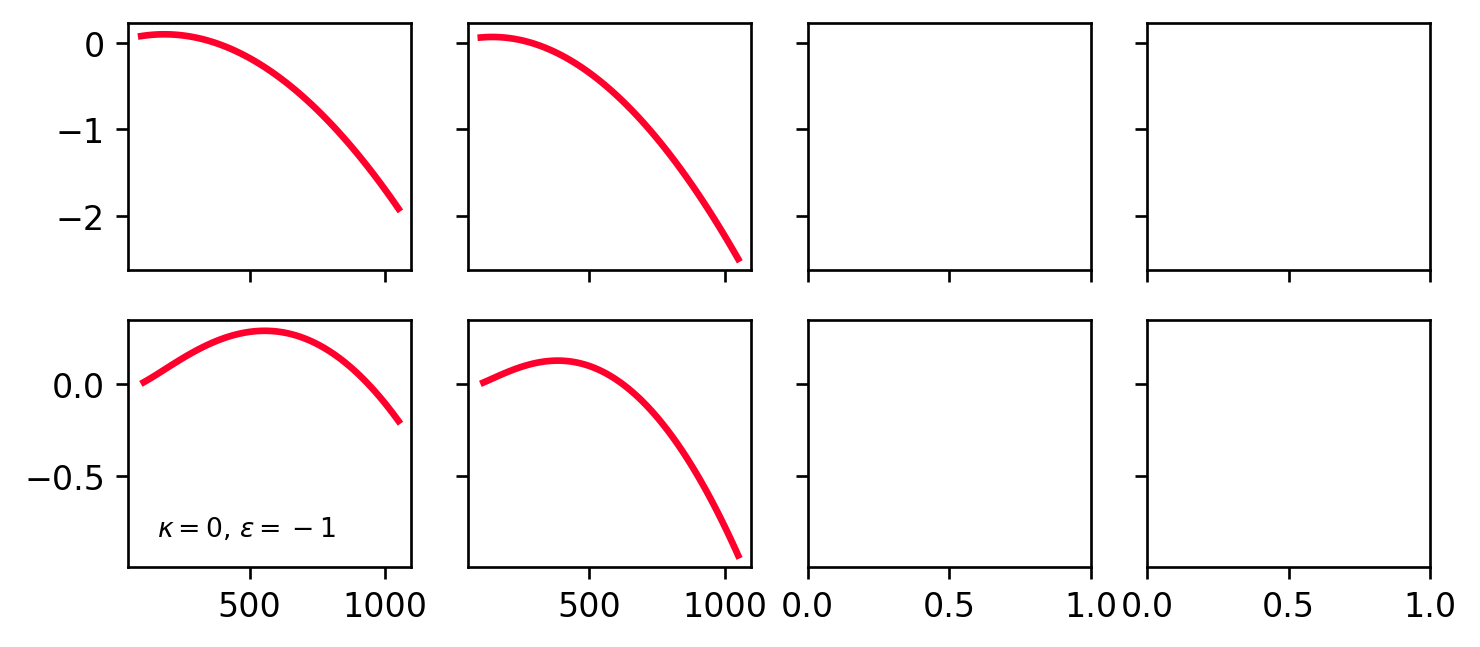

In [47]:
fig,ax=plt.subplots(2,4,figsize=(7,3),dpi=240,sharey="row",sharex="col") #, constrained_layout=True)

for epi in range(4):
    am = [0.0,2.0][epi%2]
    RT=[0.0,0.2][epi//2]
    
    # Filter data 
    df_sub = df[(df.kappa==RT) & (df.dilation==am)]
    df_sub = df_sub.sort_values("temperature")
    df_sub[df_sub.temperature >= 50.0]
    print(df_sub.T_vir_md_main.values)  
    
    equ = 1000.*kb*1.5
    
    # fine grained temperature array for integration
    fT = np.linspace(100.0,1050.0,101)
    
    # Analyse MD data 
    aUs, eUs, dF, dFeu, dFel = analyse_md(
        df_sub=df_sub, 
        equ=equ, 
        fT=fT
    )

    # Plot MD data 
    mde = ax[0,epi].fill_between(fT,y1=aUs(fT)-eUs(fT),y2=aUs(fT)+eUs(fT),facecolor=myc['r'],alpha=0.3,lw=0)
    mdp = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['r'],lw=lw)
    fe = ax[1,epi].fill_between(fT[1:],y1=dF-dFel,y2=dF+dFeu,facecolor=myc['r'],alpha=0.3,lw=0)
    fp = ax[1,epi].plot(fT[1:],dF,'-',c=myc['r'],lw=lw)
    
    rF = -dF[-1]
    
    # Anharmonic approximation 
    approx_array = calc_approximation(
        temp_array=df_sub.T_vir_md_main.values, 
        a0=a0, 
        RT=RT, 
        am=am, 
        equ=equ
    )
    
    # uncorrelated
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,1],s=0.01)
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,1],s=0.01)
    ucmf = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['b'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    ucmff = ax[1,epi].plot(fT[1:],dF,'-',c=myc['b'],lw=lw)
        
    # correlated
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,2],s=0.01) 
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,2],s=0.01)
    cmf = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['o'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    cmff = ax[1,epi].plot(fT[1:],dF,'-',c=myc['o'],lw=lw)
    
    # correlated + virial
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,3],s=0.01)
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,3],s=0.01)
    cmfv = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['g'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    cmffv = ax[1,epi].plot(fT[1:],dF,'-',c=myc['g'],lw=lw)
    rF += dF[-1]
    

    print("\n---- ERROR AT T=%dK---\n" % fT[-1],
          "\tF_mfcv-F_md: %1.4g meV/atom\n" % (-rF),
          "\tensemble error in F_md: %1.4g meV/atom\n" % (np.abs(dFel[-1])/2.0+np.abs(dFeu[-1])/2.0),
          "\tensemble error in T_vir: %1.2g K\n" % (eUs(fT)[-1]),"\n")
    
    ax[1,epi].text(0.1,0.1,r"$\kappa=%.2g$" % RT +", "+r"$\epsilon=%.2g$" % (am-1),\
         fontsize=8,transform=ax[1,epi].transAxes,horizontalalignment='left',verticalalignment='bottom')
    
        
    
"""
Formatting for plot
"""
ax[0,2].legend([(mdp[0],mde),(ucmf[0]),(cmf[0]),(cmfv[0]),],labels[1:5],
        fontsize=8,labelspacing=0.1,handlelength=1.,handletextpad=0.3,loc="lower left")
ax[0,0].set_ylabel(r"$\mathcal{U}^{\rm ah}({\rm T},\epsilon)$ [meV]",fontsize=8)
ax[1,0].set_ylabel(r"$\mathcal{F}^{\rm ah}({\rm T},\epsilon)$ [meV]",fontsize=8)

for i in range(4):
    for j in range(2):    
        ax[j,i].set_xlim(100.0,1050.0)
        ax[j,i].tick_params(axis="x", labelsize=8)
        ax[j,i].tick_params(axis="y", labelsize=8)
        ax[j,i].set_xticks([100.0,300.0,600.0,900.0])
        
    ax[1,i].set_xlabel("Temperature [K]",fontsize=8)
    

plt.tight_layout()

plt.subplots_adjust(hspace=0.1,wspace=0.1)

output_file="dEnergy_dFreeEnergy.pdf"
if not output_file is None:
    print(output_file)
    plt.savefig(output_file,bbox_inches = 'tight',pad_inches = 0)